# Task 1: Outlier Detection for Houston Weather Dataset (HW2023)
## Two Methods: (1) Density-Based | (2) Reconstruction-Based (Autoencoder)


## Imports & Setup

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print('All libraries loaded successfully.')

All libraries loaded successfully.


## Load and Explore the HW2023 Dataset

In [12]:
df = pd.read_csv('/content/HW2023.csv')
print('Shape:', df.shape)
print('\nFirst 5 rows:')
df.head()
print('\nDataFrame Columns:')
print(df.columns)

Shape: (365, 7)

First 5 rows:

DataFrame Columns:
Index(['date', 'temp_max', 'humidity', 'visibility', 'cloudiness',
       'wind_speed', 'rain'],
      dtype='object')


In [13]:
# -----------------------------------------------------------
# Explore data: types, missing values, basic stats
# -----------------------------------------------------------
print('Data types:')
print(df.dtypes)
print('\nMissing values:')
print(df.isnull().sum())
print('\nBasic statistics:')
df.describe()

Data types:
date           object
temp_max      float64
humidity      float64
visibility    float64
cloudiness    float64
wind_speed    float64
rain          float64
dtype: object

Missing values:
date            0
temp_max        0
humidity        0
visibility      0
cloudiness      0
wind_speed      0
rain          146
dtype: int64

Basic statistics:


,temp_max,humidity,visibility,cloudiness,wind_speed,rain
count,365.000000,365.000000,365.000000,365.000000,365.000000,219.000000
mean,84.926986,72.696739,9336.278096,52.021821,10.499458,8.942511
std,13.861230,10.728359,1215.408678,27.500009,3.378812,17.410766
min,42.080000,44.458333,3036.800000,0.833333,3.276667,0.100000
25%,75.090000,67.041667,9200.458333,28.708333,8.129583,0.500000
50%,85.100000,72.333333,10000.000000,49.791667,9.906250,1.610000
75%,97.110000,81.080000,10000.000000,75.416667,12.419600,8.435000
max,109.090000,95.095238,10000.000000,100.000000,21.836857,107.350000


In [16]:
# -----------------------------------------------------------
# Preprocess:
#  - Fill missing 'rain' with 0 (no entry means no rain)
#  - Select numeric feature columns
# -----------------------------------------------------------
df['rain'] = df['rain'].fillna(0)

FEATURES = ['cloudiness', 'rain', 'temp_max', 'wind_speed', 'visibility', 'humidity']

# Keep DATE separate for later analysis
X_raw = df[FEATURES].copy()

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES)

print('Features after preprocessing:')
X_scaled_df.describe().round(3)

Features after preprocessing:


,cloudiness,rain,temp_max,wind_speed,visibility,humidity
count,365.000,365.000,365.000,365.000,365.000,365.000
mean,-0.000,-0.000,-0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001
min,-1.864,-0.379,-3.095,-2.141,-5.190,-2.636
25%,-0.849,-0.379,-0.711,-0.702,-0.112,-0.528
50%,-0.081,-0.360,0.012,-0.176,0.547,-0.034
75%,0.852,-0.192,0.880,0.569,0.547,0.782
max,1.747,7.207,1.746,3.360,0.547,2.091


---
## SIMPLE Dataset — Ground Truth Test

In [17]:
# -----------------------------------------------------------
# The SIMPLE dataset (2D, ground truth known)
# Point 7 (7,6) and Point 8 (-17,-19) are known outliers
# -----------------------------------------------------------
simple = pd.DataFrame({
    'Id':   [1, 2, 3, 4, 5, 6, 7, 8],
    'Att1': [2, 3, 4, 2, 2, 1, 7, -17],
    'Att2': [2, 3, 1, 2, 4, 3, 6, -19]
})
print('SIMPLE Dataset:')
simple

SIMPLE Dataset:


,Id,Att1,Att2
0,1,2,2
1,2,3,3
2,3,4,1
3,4,2,2
4,5,2,4
5,6,1,3
6,7,7,6
7,8,-17,-19


---
## Method 1: Density-Based Outlier Detection
### Multivariate Distance Function (Mahalanobis Distance)

We use **Mahalanobis distance** as our distance function because it accounts for feature correlations and scales — unlike Euclidean distance it treats correlated features correctly.

$$d_{Mah}(x, \mu) = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}$$

### Density Function: Gaussian Mixture Model (GMM)

We fit a **Gaussian Mixture Model** to the data. The density of a point is the **log-likelihood** under the fitted GMM. Low density → high outlier score.

In [18]:
# -----------------------------------------------------------
# Helper: Mahalanobis distance
# -----------------------------------------------------------
def mahalanobis_distance(X, mean, cov):
    """Compute Mahalanobis distance for each row of X."""
    diff = X - mean
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # use pseudo-inverse if singular
    dist = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
    return dist

# -----------------------------------------------------------
# GMM-based density outlier detection
# OLS = -log_likelihood normalized to [0,1] (higher = more outlier)
# -----------------------------------------------------------
def gmm_outlier_detection(X, n_components=3, covariance_type='full'):
    """
    Fit a Gaussian Mixture Model and compute outlier scores.
    OLS = normalized negative log-likelihood (1 = most anomalous, 0 = most normal).
    """
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type=covariance_type,
                          random_state=42)
    gmm.fit(X)
    log_likelihood = gmm.score_samples(X)  # log p(x)
    # Invert: lower density (more negative log-likelihood) = higher OLS
    neg_log_lik = -log_likelihood
    ols = (neg_log_lik - neg_log_lik.min()) / (neg_log_lik.max() - neg_log_lik.min())
    return ols, gmm, log_likelihood

print('GMM outlier detection function defined.')

GMM outlier detection function defined.


In [19]:
# -----------------------------------------------------------
# Apply GMM to SIMPLE dataset first to validate
# -----------------------------------------------------------
simple_X = simple[['Att1', 'Att2']].values
simple_X_scaled = StandardScaler().fit_transform(simple_X)

ols_simple_gmm, _, _ = gmm_outlier_detection(simple_X_scaled, n_components=2)
simple['OLS_GMM'] = ols_simple_gmm.round(4)
print('SIMPLE Dataset with GMM Outlier Scores (sorted):')
simple[['Id','Att1','Att2','OLS_GMM']].sort_values('OLS_GMM', ascending=False)

SIMPLE Dataset with GMM Outlier Scores (sorted):


,Id,Att1,Att2,OLS_GMM
6,7,7,6,1.0000
2,3,4,1,0.9401
5,6,1,3,0.8341
4,5,2,4,0.8318
0,1,2,2,0.7811
3,4,2,2,0.7811
1,2,3,3,0.7604
7,8,-17,-19,0.0000


In [20]:
# -----------------------------------------------------------
# Task b: Apply GMM to HW2023 with 3 hyperparameter settings
# Hyperparameter: n_components (number of Gaussians)
# -----------------------------------------------------------
gmm_results = {}
gmm_settings = [
    {'n_components': 2, 'covariance_type': 'full'},
    {'n_components': 4, 'covariance_type': 'full'},
    {'n_components': 6, 'covariance_type': 'full'},
]

for i, params in enumerate(gmm_settings):
    name = f"GMM_k{params['n_components']}"
    ols, model, ll = gmm_outlier_detection(X_scaled, **params)
    gmm_results[name] = ols
    print(f"Setting {i+1}: n_components={params['n_components']} | "
          f"Mean OLS={ols.mean():.4f} | Max OLS={ols.max():.4f}")

Setting 1: n_components=2 | Mean OLS=0.2863 | Max OLS=1.0000
Setting 2: n_components=4 | Mean OLS=0.2641 | Max OLS=1.0000
Setting 3: n_components=6 | Mean OLS=0.3459 | Max OLS=1.0000


In [22]:
# -----------------------------------------------------------
# Augment HW2023 with GMM outlier scores
# -----------------------------------------------------------
df_gmm = df.copy()
for name, ols in gmm_results.items():
    df_gmm[name] = ols

print('HW2023 dataset with GMM OLS columns added:')
df_gmm[['date'] + list(gmm_results.keys())].head(10)

HW2023 dataset with GMM OLS columns added:


,date,GMM_k2,GMM_k4,GMM_k6
0,1/1/2023,0.388981,0.344425,0.456321
1,1/2/2023,0.464490,0.485262,0.552462
2,1/3/2023,0.382529,0.352175,0.496381
3,1/4/2023,0.094889,0.135030,0.226709
4,1/5/2023,0.095355,0.124270,0.214645
5,1/6/2023,0.398711,0.355033,0.452025
6,1/7/2023,0.382189,0.334885,0.445566
7,1/8/2023,0.802238,0.571256,0.685659
8,1/9/2023,0.641767,0.325326,0.434350
9,1/10/2023,0.397112,0.345728,0.441873


In [24]:
# -----------------------------------------------------------
# Task c: Sort by OLS and inspect top 4 and bottom 2 outliers
# (Using GMM_k4 as the primary setting)
# -----------------------------------------------------------
primary_gmm = 'GMM_k4'

df_gmm_sorted = df_gmm[['date'] + FEATURES + [primary_gmm]].sort_values(primary_gmm, ascending=False)

print('=== TOP 4 OUTLIERS (GMM, k=4) ===')
print(df_gmm_sorted.head(4).to_string(index=False))

print('\n=== BOTTOM 2 (Most Normal) (GMM, k=4) ===')
print(df_gmm_sorted.tail(2).to_string(index=False))

=== TOP 4 OUTLIERS (GMM, k=4) ===
      date  cloudiness   rain  temp_max  wind_speed  visibility  humidity   GMM_k4
12/10/2023   51.730769  19.67     73.02   19.649615 9393.120000 51.961538 1.000000
 1/24/2023   95.714286 107.35     71.58   21.836857 6547.827586 83.257143 0.712797
 1/31/2023  100.000000   2.04     45.05   13.699630 3036.800000 93.000000 0.677593
 1/21/2023   99.000000  18.47     56.05   12.894800 9190.920000 80.360000 0.673780

=== BOTTOM 2 (Most Normal) (GMM, k=4) ===
     date  cloudiness  rain  temp_max  wind_speed  visibility  humidity   GMM_k4
9/29/2023   40.750000  0.49     94.05    8.350833     10000.0 72.791667 0.005085
 9/3/2023   32.708333  0.00    101.08    8.531250     10000.0 67.041667 0.000000


---
## Method 2: Reconstruction-Based Outlier Detection (Autoencoder)

An **Autoencoder** is a neural network that learns to compress (encode) data into a lower-dimensional representation and then reconstruct (decode) it back. After training on normal data, **anomalous points** will have **high reconstruction error** because they don't fit the learned patterns.

**Architecture:** Input(6) → Encoder [64→32→latent_dim] → Decoder [latent_dim→32→64→6] → Output(6)

**OLS = Mean Squared Error (MSE)** between input and reconstruction, normalized to [0,1].

In [25]:
# -----------------------------------------------------------
# Define the Autoencoder Architecture
# -----------------------------------------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim=6, latent_dim=3):
        super(Autoencoder, self).__init__()
        # Encoder: compresses input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        # Decoder: reconstructs input from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def train_autoencoder(X_scaled, latent_dim=3, epochs=200, lr=0.001, batch_size=32):
    """
    Train an autoencoder on scaled data X and return per-sample MSE reconstruction errors.
    Returns: normalized OLS array, model
    """
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_scaled)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction='none')  # per-element loss

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x).mean()  # mean over batch
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 50 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.6f}')

    # Compute reconstruction error for each sample
    model.eval()
    with torch.no_grad():
        X_hat = model(X_tensor)
        # Per-sample MSE (mean over features)
        mse = criterion(X_hat, X_tensor).mean(dim=1).numpy()

    # Normalize to [0,1]
    ols = (mse - mse.min()) / (mse.max() - mse.min())
    return ols, model, mse

print('Autoencoder architecture defined.')

Autoencoder architecture defined.


In [26]:
# -----------------------------------------------------------
# Apply Autoencoder to SIMPLE dataset first (validation)
# -----------------------------------------------------------
print('Training Autoencoder on SIMPLE dataset...')
simple_X_scaled2 = StandardScaler().fit_transform(simple[['Att1','Att2']].values)
ols_simple_ae, _, _ = train_autoencoder(simple_X_scaled2, latent_dim=1, epochs=300, lr=0.01)
simple['OLS_AE'] = ols_simple_ae.round(4)

print('\nSIMPLE Dataset with Autoencoder OLS (sorted):')
simple[['Id','Att1','Att2','OLS_GMM','OLS_AE']].sort_values('OLS_AE', ascending=False)

Training Autoencoder on SIMPLE dataset...
  Epoch [50/300], Loss: 0.010547
  Epoch [100/300], Loss: 0.005294
  Epoch [150/300], Loss: 0.003110
  Epoch [200/300], Loss: 0.002082
  Epoch [250/300], Loss: 0.000442
  Epoch [300/300], Loss: 0.000168

SIMPLE Dataset with Autoencoder OLS (sorted):


,Id,Att1,Att2,OLS_GMM,OLS_AE
6,7,7,6,1.0000,1.0000
1,2,3,3,0.7604,0.2576
7,8,-17,-19,0.0000,0.0380
2,3,4,1,0.9401,0.0204
5,6,1,3,0.8341,0.0040
0,1,2,2,0.7811,0.0023
3,4,2,2,0.7811,0.0023
4,5,2,4,0.8318,0.0000


In [27]:
# -----------------------------------------------------------
# Task b: Apply Autoencoder to HW2023 with 3 hyperparameter settings
# Hyperparameter varied: latent_dim (bottleneck size)
# -----------------------------------------------------------
ae_results = {}
ae_settings = [
    {'latent_dim': 2, 'epochs': 300, 'lr': 0.001},  # very compressed
    {'latent_dim': 3, 'epochs': 300, 'lr': 0.001},  # moderate
    {'latent_dim': 5, 'epochs': 300, 'lr': 0.001},  # less compressed
]

for i, params in enumerate(ae_settings):
    name = f"AE_latent{params['latent_dim']}"
    print(f"\nTraining {name}...")
    ols, model, raw_mse = train_autoencoder(X_scaled, **params)
    ae_results[name] = ols
    print(f"  Mean OLS={ols.mean():.4f} | Max OLS={ols.max():.4f}")


Training AE_latent2...
  Epoch [50/300], Loss: 0.142249
  Epoch [100/300], Loss: 0.124049
  Epoch [150/300], Loss: 0.115547
  Epoch [200/300], Loss: 0.102484
  Epoch [250/300], Loss: 0.104543
  Epoch [300/300], Loss: 0.093924
  Mean OLS=0.1044 | Max OLS=1.0000

Training AE_latent3...
  Epoch [50/300], Loss: 0.073203
  Epoch [100/300], Loss: 0.055386
  Epoch [150/300], Loss: 0.045187
  Epoch [200/300], Loss: 0.037245
  Epoch [250/300], Loss: 0.034210
  Epoch [300/300], Loss: 0.031143
  Mean OLS=0.0826 | Max OLS=1.0000

Training AE_latent5...
  Epoch [50/300], Loss: 0.013425
  Epoch [100/300], Loss: 0.008605
  Epoch [150/300], Loss: 0.005752
  Epoch [200/300], Loss: 0.005204
  Epoch [250/300], Loss: 0.003801
  Epoch [300/300], Loss: 0.002943
  Mean OLS=0.0288 | Max OLS=1.0000


In [29]:
# -----------------------------------------------------------
# Augment HW2023 with Autoencoder outlier scores
# -----------------------------------------------------------
df_ae = df.copy()
for name, ols in ae_results.items():
    df_ae[name] = ols

# Primary AE setting for analysis
primary_ae = 'AE_latent3'

df_ae_sorted = df_ae[['date'] + FEATURES + [primary_ae]].sort_values(primary_ae, ascending=False)

print('=== TOP 4 OUTLIERS (Autoencoder, latent_dim=3) ===')
print(df_ae_sorted.head(4).to_string(index=False))

print('\n=== BOTTOM 2 (Most Normal) (Autoencoder, latent_dim=3) ===')
print(df_ae_sorted.tail(2).to_string(index=False))

=== TOP 4 OUTLIERS (Autoencoder, latent_dim=3) ===
      date  cloudiness  rain  temp_max  wind_speed   visibility  humidity  AE_latent3
 6/22/2023        27.5 23.22    100.11   10.446154 10000.000000 71.461538    1.000000
  7/7/2023        54.0 16.27     91.38    7.223846  9240.434783 86.961538    0.694818
 9/26/2023        42.8 23.58     94.05    5.485600 10000.000000 80.560000    0.664783
11/10/2023        97.5 49.12     72.09   10.154500  4980.100000 94.875000    0.550585

=== BOTTOM 2 (Most Normal) (Autoencoder, latent_dim=3) ===
     date  cloudiness  rain  temp_max  wind_speed  visibility  humidity  AE_latent3
7/28/2023   19.583333   0.0    100.06    6.586250     10000.0 66.541667    0.000465
7/31/2023   36.333333   0.0    105.12    6.791667     10000.0 64.750000    0.000000


---
## Task d: Compare the Two Methods

Pearson correlation between GMM and AE outlier scores: 0.3095


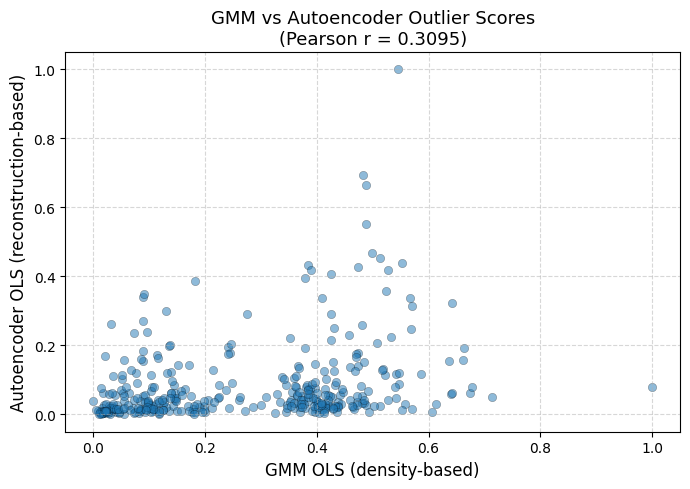

Saved: method_comparison_scatter.png


In [31]:
# -----------------------------------------------------------
# Correlation between GMM and Autoencoder OLS scores
# -----------------------------------------------------------
comparison_df = pd.DataFrame({
    'DATE': df['date'],
    'OLS_GMM': gmm_results[primary_gmm],
    'OLS_AE': ae_results[primary_ae]
})

corr = comparison_df[['OLS_GMM','OLS_AE']].corr().iloc[0,1]
print(f'Pearson correlation between GMM and AE outlier scores: {corr:.4f}')

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(comparison_df['OLS_GMM'], comparison_df['OLS_AE'], alpha=0.5, edgecolors='k', linewidths=0.3)
plt.xlabel('GMM OLS (density-based)', fontsize=12)
plt.ylabel('Autoencoder OLS (reconstruction-based)', fontsize=12)
plt.title(f'GMM vs Autoencoder Outlier Scores\n(Pearson r = {corr:.4f})', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('method_comparison_scatter.png', dpi=150)
plt.show()
print('Saved: method_comparison_scatter.png')

In [33]:
# -----------------------------------------------------------
# Top 10 anomalous days comparison (optional task b)
# -----------------------------------------------------------
top10_gmm = set(df_gmm.nlargest(10, primary_gmm)['date'].astype(str))
top10_ae  = set(df_ae.nlargest(10, primary_ae)['date'].astype(str))

common = top10_gmm & top10_ae
print(f'Days in GMM top-10: {sorted(top10_gmm)}')
print(f'Days in AE top-10:  {sorted(top10_ae)}')
print(f'Overlap: {sorted(common)} ({len(common)}/10 days in common)')

Days in GMM top-10: ['1/20/2023', '1/21/2023', '1/24/2023', '1/31/2023', '10/6/2023', '12/10/2023', '12/25/2023', '2/1/2023', '2/2/2023', '3/18/2023']
Days in AE top-10:  ['10/14/2023', '11/10/2023', '12/15/2023', '12/24/2023', '4/6/2023', '6/22/2023', '7/7/2023', '9/14/2023', '9/16/2023', '9/26/2023']
Overlap: [] (0/10 days in common)


---
## 6. Visualizations

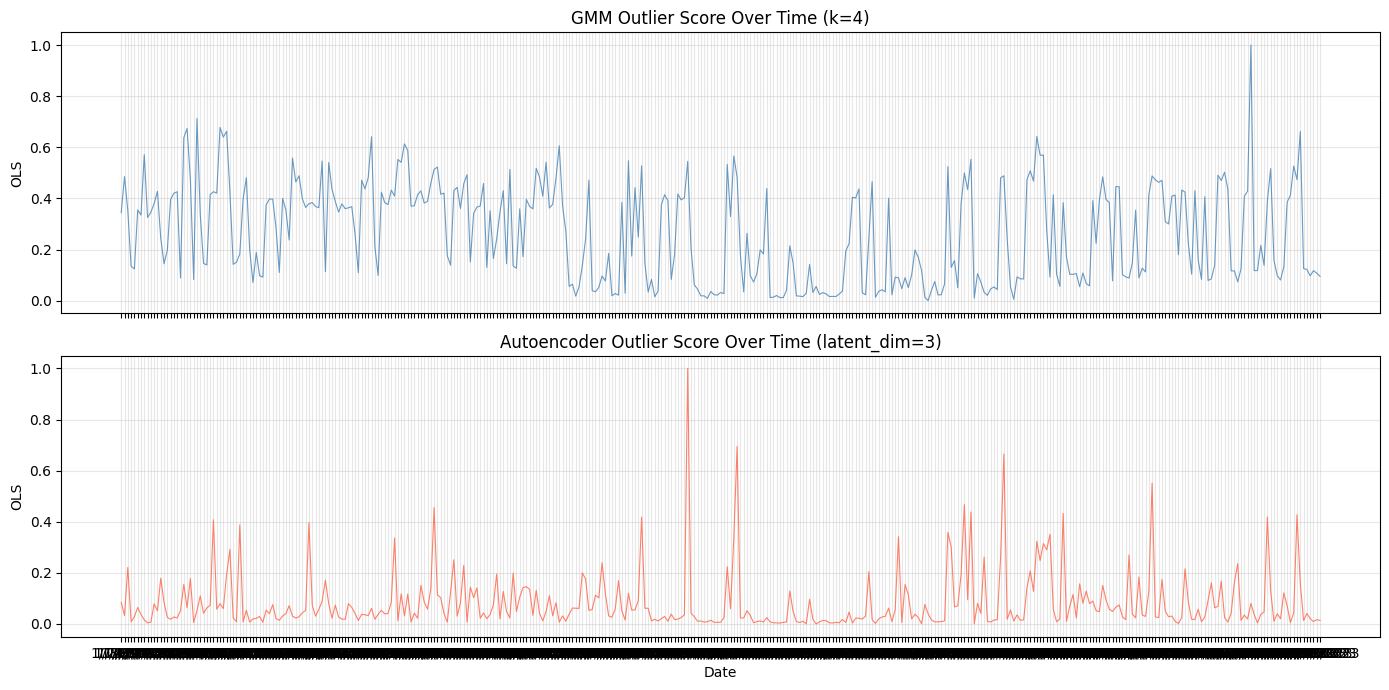

Saved: ols_over_time.png


In [36]:
# -----------------------------------------------------------
# OLS over time (both methods)
# -----------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(df['date'], gmm_results[primary_gmm], color='steelblue', lw=0.8, alpha=0.8)
axes[0].set_title('GMM Outlier Score Over Time (k=4)', fontsize=12)
axes[0].set_ylabel('OLS')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['date'], ae_results[primary_ae], color='tomato', lw=0.8, alpha=0.8)
axes[1].set_title('Autoencoder Outlier Score Over Time (latent_dim=3)', fontsize=12)
axes[1].set_ylabel('OLS')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ols_over_time.png', dpi=150)
plt.show()
print('Saved: ols_over_time.png')

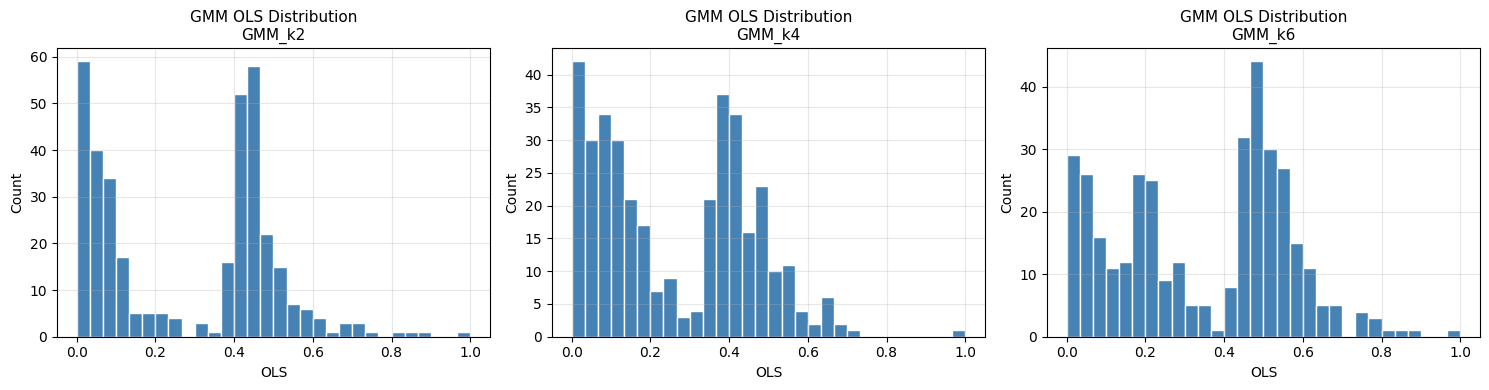

Saved: gmm_hyperparameter_comparison.png


In [37]:
# -----------------------------------------------------------
# Hyperparameter comparison: GMM with 3 different k
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, ols) in zip(axes, gmm_results.items()):
    ax.hist(ols, bins=30, color='steelblue', edgecolor='white')
    ax.set_title(f'GMM OLS Distribution\n{name}', fontsize=11)
    ax.set_xlabel('OLS')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gmm_hyperparameter_comparison.png', dpi=150)
plt.show()
print('Saved: gmm_hyperparameter_comparison.png')

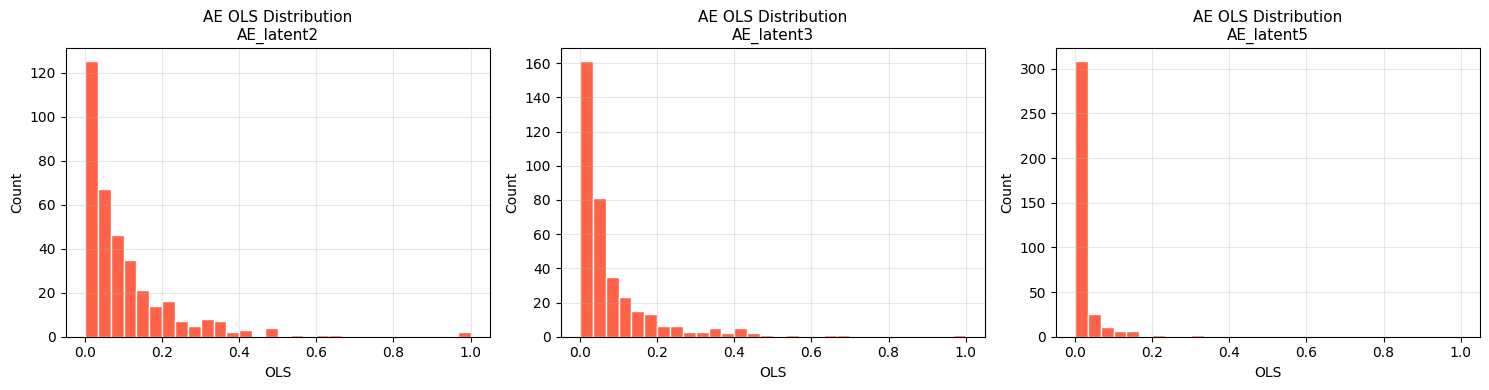

Saved: ae_hyperparameter_comparison.png


In [38]:
# -----------------------------------------------------------
# Hyperparameter comparison: AE with 3 different latent_dims
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, ols) in zip(axes, ae_results.items()):
    ax.hist(ols, bins=30, color='tomato', edgecolor='white')
    ax.set_title(f'AE OLS Distribution\n{name}', fontsize=11)
    ax.set_xlabel('OLS')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ae_hyperparameter_comparison.png', dpi=150)
plt.show()
print('Saved: ae_hyperparameter_comparison.png')

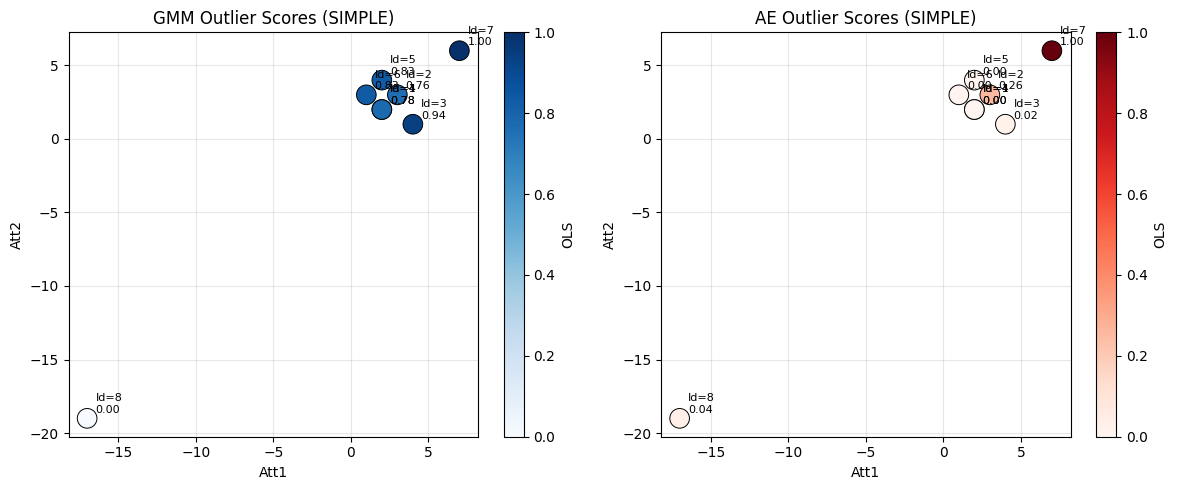

Saved: simple_dataset_visualization.png


In [39]:
# -----------------------------------------------------------
# SIMPLE dataset scatter (visualize outlier scores)
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col, title, cmap in [
    (axes[0], 'OLS_GMM', 'GMM Outlier Scores (SIMPLE)', 'Blues'),
    (axes[1], 'OLS_AE',  'AE Outlier Scores (SIMPLE)',  'Reds')
]:
    sc = ax.scatter(simple['Att1'], simple['Att2'],
                    c=simple[col], cmap=cmap, s=200,
                    edgecolors='black', linewidths=0.7, vmin=0, vmax=1)
    for _, row in simple.iterrows():
        ax.annotate(f"Id={int(row['Id'])}\n{row[col]:.2f}",
                    (row['Att1'], row['Att2']),
                    textcoords='offset points', xytext=(6, 4), fontsize=8)
    plt.colorbar(sc, ax=ax, label='OLS')
    ax.set_xlabel('Att1')
    ax.set_ylabel('Att2')
    ax.set_title(title, fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_dataset_visualization.png', dpi=150)
plt.show()
print('Saved: simple_dataset_visualization.png')

---
## Optional: Quarterly Outlier Drift Analysis (Task c Optional)

In [42]:
# -----------------------------------------------------------
# Divide 2023 into 4 quarters and analyze outlier drift
# -----------------------------------------------------------
df_full = df.copy()
df_full['OLS_GMM'] = gmm_results[primary_gmm]
df_full['OLS_AE']  = ae_results[primary_ae]

# Convert 'date' column to datetime type
df_full['date'] = pd.to_datetime(df_full['date'])

# Assign quarters
df_full['Quarter'] = df_full['date'].dt.quarter
quarter_names = {1: 'Q1 (Jan-Mar)', 2: 'Q2 (Apr-Jun)',
                 3: 'Q3 (Jul-Sep)', 4: 'Q4 (Oct-Dec)'}
df_full['Quarter_Name'] = df_full['Quarter'].map(quarter_names)

# Threshold = 75th percentile (top 25% = outlier for rate calculation)
threshold_gmm = df_full['OLS_GMM'].quantile(0.75)
threshold_ae  = df_full['OLS_AE'].quantile(0.75)

quarterly_stats = []
for q in [1, 2, 3, 4]:
    sub = df_full[df_full['Quarter'] == q]
    outlier_rate_gmm = (sub['OLS_GMM'] >= threshold_gmm).mean() * 100
    outlier_rate_ae  = (sub['OLS_AE']  >= threshold_ae ).mean() * 100
    avg_gmm = sub['OLS_GMM'].mean()
    avg_ae  = sub['OLS_AE'].mean()
    quarterly_stats.append({
        'Quarter': quarter_names[q],
        'Outlier Rate GMM (%)': round(outlier_rate_gmm, 1),
        'Outlier Rate AE (%)':  round(outlier_rate_ae,  1),
        'Avg OLS GMM': round(avg_gmm, 4),
        'Avg OLS AE':  round(avg_ae,  4),
    })

quarterly_df = pd.DataFrame(quarterly_stats)
print('Quarterly Outlier Statistics:')
print(quarterly_df.to_string(index=False))

Quarterly Outlier Statistics:
     Quarter  Outlier Rate GMM (%)  Outlier Rate AE (%)  Avg OLS GMM  Avg OLS AE
Q1 (Jan-Mar)                  35.6                 15.6       0.3657      0.0703
Q2 (Apr-Jun)                  24.2                 33.0       0.2712      0.0888
Q3 (Jul-Sep)                  13.0                 19.6       0.1434      0.0748
Q4 (Oct-Dec)                  28.3                 32.6       0.2782      0.0963


In [44]:
# -----------------------------------------------------------
# Top 3 most anomalous days per quarter
# -----------------------------------------------------------
for q in [1, 2, 3, 4]:
    sub = df_full[df_full['Quarter'] == q]
    print(f"\n{quarter_names[q]} — Top 3 (GMM):")
    print(sub.nlargest(3, 'OLS_GMM')[['date','OLS_GMM','temp_max','humidity','wind_speed','rain']].to_string(index=False))
    print(f"{quarter_names[q]} — Top 3 (AE):")
    print(sub.nlargest(3, 'OLS_AE')[['date','OLS_AE','temp_max','humidity','wind_speed','rain']].to_string(index=False))


Q1 (Jan-Mar) — Top 3 (GMM):
      date  OLS_GMM  temp_max  humidity  wind_speed   rain
2023-01-24 0.712797     71.58 83.257143   21.836857 107.35
2023-01-31 0.677593     45.05 93.000000   13.699630   2.04
2023-01-21 0.673780     56.05 80.360000   12.894800  18.47
Q1 (Jan-Mar) — Top 3 (AE):
      date   OLS_AE  temp_max  humidity  wind_speed  rain
2023-01-29 0.407690     75.92 87.382353   14.185588 27.23
2023-02-27 0.396487     85.05 69.000000   14.129167  0.00
2023-02-06 0.387312     75.11 80.416667   15.566667  0.00

Q2 (Apr-Jun) — Top 3 (GMM):
      date  OLS_GMM  temp_max  humidity  wind_speed   rain
2023-05-14 0.606205     85.05 90.388889   14.384167 104.28
2023-06-04 0.547326     93.15 69.153846    8.825385  10.46
2023-06-22 0.545163    100.11 71.461538   10.446154  23.22
Q2 (Apr-Jun) — Top 3 (AE):
      date   OLS_AE  temp_max  humidity  wind_speed  rain
2023-06-22 1.000000    100.11 71.461538   10.446154 23.22
2023-04-06 0.454803     66.18 90.379310   14.919310 10.59
2023-06-08

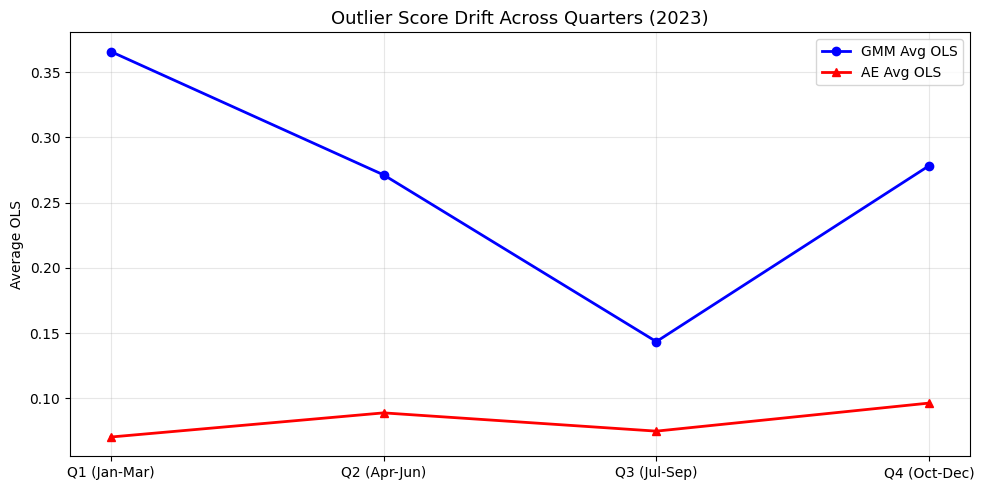

Saved: quarterly_drift.png


In [45]:
# -----------------------------------------------------------
# Visualize outlier drift over quarters
# -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
x = range(1, 5)
ax.plot(x, quarterly_df['Avg OLS GMM'], 'bo-', label='GMM Avg OLS', lw=2)
ax.plot(x, quarterly_df['Avg OLS AE'],  'r^-', label='AE Avg OLS',  lw=2)
ax.set_xticks(list(x))
ax.set_xticklabels([quarter_names[q] for q in x], fontsize=10)
ax.set_ylabel('Average OLS')
ax.set_title('Outlier Score Drift Across Quarters (2023)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('quarterly_drift.png', dpi=150)
plt.show()
print('Saved: quarterly_drift.png')

---
## Save Final Augmented Datasets

In [46]:
# -----------------------------------------------------------
# Save augmented datasets to CSV
# -----------------------------------------------------------
# HW2023 + all GMM OLS columns
df_gmm.to_csv('HW2023_GMM_Outliers.csv', index=False)

# HW2023 + all AE OLS columns
df_ae.to_csv('HW2023_AE_Outliers.csv', index=False)

# SIMPLE dataset with both OLS columns
simple.to_csv('SIMPLE_Outliers.csv', index=False)

print('Saved:')
print('  HW2023_GMM_Outliers.csv')
print('  HW2023_AE_Outliers.csv')
print('  SIMPLE_Outliers.csv')

Saved:
  HW2023_GMM_Outliers.csv
  HW2023_AE_Outliers.csv
  SIMPLE_Outliers.csv


In [47]:
# -----------------------------------------------------------
# Appendix: Print final SIMPLE dataset results for report
# -----------------------------------------------------------
print('=== APPENDIX: SIMPLE Dataset — GMM Results ===')
print(simple[['Id','Att1','Att2','OLS_GMM']].sort_values('OLS_GMM', ascending=False).to_string(index=False))

print('\n=== APPENDIX: SIMPLE Dataset — Autoencoder Results ===')
print(simple[['Id','Att1','Att2','OLS_AE']].sort_values('OLS_AE', ascending=False).to_string(index=False))

=== APPENDIX: SIMPLE Dataset — GMM Results ===
 Id  Att1  Att2  OLS_GMM
  7     7     6   1.0000
  3     4     1   0.9401
  6     1     3   0.8341
  5     2     4   0.8318
  1     2     2   0.7811
  4     2     2   0.7811
  2     3     3   0.7604
  8   -17   -19   0.0000

=== APPENDIX: SIMPLE Dataset — Autoencoder Results ===
 Id  Att1  Att2  OLS_AE
  7     7     6  1.0000
  2     3     3  0.2576
  8   -17   -19  0.0380
  3     4     1  0.0204
  6     1     3  0.0040
  1     2     2  0.0023
  4     2     2  0.0023
  5     2     4  0.0000
